In [137]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def display_all_regions(regions):
    for i in range(0,len(regions)):
        plt.figure(figsize=(3,3))
        display_image(regions[i])
        
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def resize_region(region):
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))       
    return ready_for_ann

def convert_output(outputs):
    return np.eye(len(outputs))

def create_ann():
    ann = Sequential()
    ann.add(Dense(input_dim=1568, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=52,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=2000, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

def winner(output): # output je vektor sa izlaza neuronske mreze
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

def write_hand(result):
    hand = ''
    for i in range(0,len(result)):
        hand += result[i]
        hand += ' '
    file = open('hand.txt','w')
    file.write(hand)
    file.close()
    
def select_roi(image_orig, image_bin):
    img, contour_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = []
    contour_centers = []
    contour_sizes = []
    
    for contour in contour_borders: 
        center, size, angle = cv2.minAreaRect(contour)
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area < 100 and h < 100 and 5 and h > 8 and w > 5:
            region = image_bin[y:y+h+1,x:x+w+1]
            contours.append(resize_region(region))
            contour_centers.append(center)
            contour_sizes.append(size)    
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),1)
    
    contours, position = merge_regions(contours, contour_centers, contour_sizes) #spajanje kontura
    
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for i,contour in enumerate(contours):
        regions_dic[position[i]] = contour
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()

    return image_orig, sorted_regions

def select_roi2(image_orig, image_bin):
    img, contour_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = []
    contour_centers = []
    contour_sizes = []
    
    for contour in contour_borders: 
        center, size, angle = cv2.minAreaRect(contour)
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if h < 250 and w < 200 and h > 100 and w > 30:
            region = image_bin[y:y+h+1,x:x+w+1]
            contours.append(resize_region(region))
            contour_centers.append(center)
            contour_sizes.append(size)    
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),1)
    
    contours, position = merge_regions(contours, contour_centers, contour_sizes) #spajanje kontura
    
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for i,contour in enumerate(contours):
        regions_dic[position[i]] = contour
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()

    return image_orig, sorted_regions

def merge_regions(contours, contour_centers, contour_sizes):
    ret_val = []
    merged_index = [] #lista indeksa kontura koje su već spojene sa nekim
    position = []
    
    for i,contour1 in enumerate(contours): #znak (srce, pik, karo, tref)
        if i in merged_index:
            continue
        center1 = contour_centers[i]
        size1 = contour_sizes[i]        
        for j,contour2 in enumerate(contours): #broj (1,2,..,Q,K)
            if j in merged_index or i == j:
                continue
            center2 = contour_centers[j]
            size2 = contour_sizes[j]
            
            if center2[0]-size2[0]/2 < center1[0] < center2[0]+size2[0]/2: #da li iznad ima kontura
                #spajanje kontura
                ret_val.append(np.concatenate((contour2,contour1)))
                position.append(center1[0])
                merged_index.append(i)
                merged_index.append(j)       
                    
    #svi regioni koji se nisu ni sa kim spojili idu u listu kontura, bez spajanja
    for idx,contour in enumerate(contours):
        if idx not in merged_index:
            ret_val.append(contour)
            position.append(contour_centers[idx][0])

    return ret_val, position

52


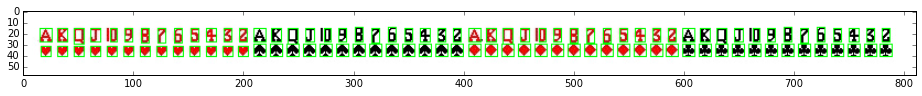

In [132]:
# Obucavanje neuronske mreze 
image_color = load_image('train.jpg')
img = invert(image_bin(image_gray(image_color)))
selected_regions, cards = select_roi(image_color.copy(), img)
display_image(selected_regions)
print len(cards)

In [88]:
alphabet = ['AH','KH','QH','JH','10H','9H','8H','7H','6H','5H','4H','3H','2H',
            'AS','KS','QS','JS','10S','9S','8S','7S','6S','5S','4S','3S','2S',
            'AD','KD','QD','JD','10D','9D','8D','7D','6D','5D','4D','3D','2D',
            'AC','KC','QC','JC','10C','9C','8C','7C','6C','5C','4C','3C','2C']            

inputs = prepare_for_ann(cards)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

result = ann.predict(np.array(inputs, np.float32))
write_hand(display_result(result, alphabet))

2


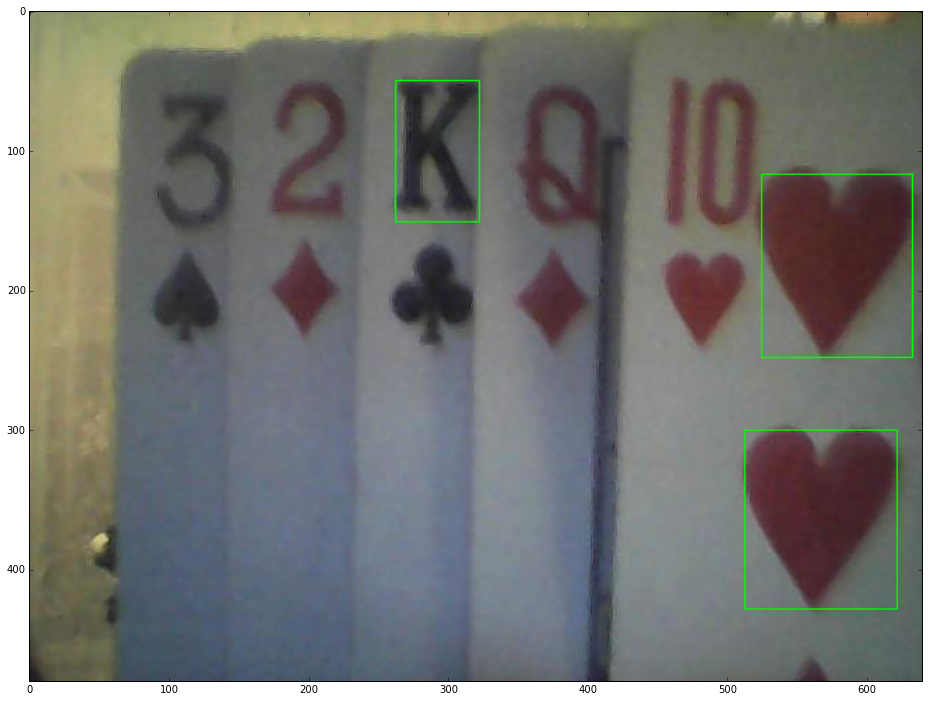

In [139]:
image_color = load_image('hand2.jpg')
img = invert(erode(dilate(erode(dilate(image_bin_adaptive(image_gray(image_color)))))))
selected_regions, cards = select_roi2(image_color.copy(), img)
display_image(selected_regions)
print len(cards)
#result = ann.predict(np.array(inputs, np.float32))
#write_hand(display_result(result, alphabet))